# Modélisation du rabattement de la nappe en fonction du temps pour un débit de pompage gaussien

Ce code (en 5 étapes) vous permet d'obtenir une modélisation du rabattement de la nappe pour une loi que vous choisissez : Theis ou Hantush.


Tout d'abord il faut importer les bibliothèques nécessaires aux calculs.

In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expn
from scipy.integrate import quad

### **1. Choix de la loi pour le rabattement**

**Veuillez indiquer** dans la case suivante quelle loi vous souhaitez utiliser pour modéliser le rabattement :  
0 pour **Theis**  
1 pour **Hantush**

In [ ]:
loi = 0

**Aide au choix:**

Utiliser Theis si l'aquifère est **captif/fermé**.

Utiliser Hantush si l'aquifère est **semi-captif** (c'est-à-dire qu'une couche semi-perméable introduit une fuite).

**Expressions mathématiques du rabattement:**
- par la loi de Theis :

$$
s(r,t) = \frac{Q}{4\pi T} \int_{u}^{+\infty} \frac{e^{-x}}{x}\, \mathrm{d}x
       = \frac{Q}{4\pi T}\, W(u)
$$

avec

$$
u = \frac{S_y r^2}{4 T t},
\qquad
W(u) = \int_{u}^{+\infty} \frac{e^{-x}}{x}\, \mathrm{d}x
$$


- par la loi d'Hantush :

$$
s(t) = \frac{1}{4\pi T}
\int_{0}^{t}
Q(\tau)\,
\exp\!\left[
-\,u(t-\tau)
- \frac{1}{4\,u(t-\tau)}\left(\frac{r_b}{B}\right)^2
\right]\,
\frac{1}{t-\tau}\,
\mathrm{d}\tau
$$

avec

$$
u(t) = \frac{S\, r_b^2}{4 T t}
$$


**Ressources supplémentaires:**

[Outil pédagogique pour prendre en main ses formules](https://gw-project.org/fr/interactive-education/pumping-test-analysis/)

### **2. Choix des paramètres**

Dans la cellule suivante **veuillez indiquer** la valeur des paramètres suivants :
- la transmissivité T
- le coefficient d'emmagasinement (ou Storativity) S
- le rapport $\dfrac{r}{B}$ qui caractérise la loi d'Hantush (Si vous avez choisi la loi de Theis, vous n'avez pas besoin de le modifier)
- Le coefficient de perte de charge quadratique appelé `coef_PCQ`

In [ ]:
# --- Paramètres
r = 0.05      # m --> distance entre la mesure et le lieu de pompage
T = 1e-5      # m2/s  --> Transmissivité
S = 1e-2            # --> Coefficient d'emmagasinement
r_sur_B = 0.005
coef_PCQ = 1000   # compris entre 0 et 10000 et s'exprime en s²/m^5

### **3. Profil de débit de pompage**

Dans la cellule suivante, **veuillez choisir** le **nombre de jours** (nb_jours) sur lesquels vous souhaitez observer le rabattement.

In [ ]:
nb_jours = 1000       # <<< Choisir ici le nombre de jours

Nous définissons la **fenêtre temporelle** sur laquelle on simule l'évolution du rabattement puis le **profil de débit de pompage** suivant la tendance de la courbe d'irradiance journalière (gaussienne).

In [ ]:
# -----------------------------
# PARAMÈTRES TEMPORELS : SIMULATION SUR N JOURS
# -----------------------------
nb_points_par_jour = 50   # Résolution temporelle d'un jour
nb_points = nb_points_par_jour * nb_jours

# Temps en heures (0 → nb_jours*24)
heures = np.linspace(0, 24 * nb_jours, nb_points)

# Temps en secondes
t_sec = heures * 3600

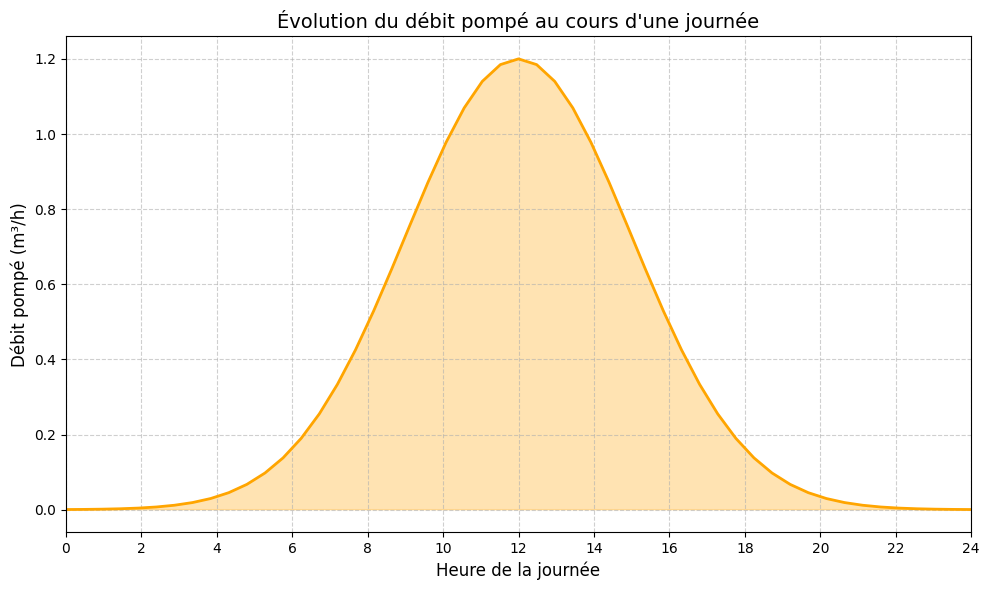

In [ ]:
# -----------------------------
# PROFIL DE DÉBIT SOLAIRE SUR N JOURS
# -----------------------------

heure_pic = 12
amplitude = 1.2
ecart_type = 3

# Profil solaire répétitif : modulo 24h
heures_mod = heures % 24

debit_h = amplitude * np.exp(-((heures_mod - heure_pic) ** 2) / (2 * ecart_type ** 2))

# Ajout de bruit --> Si vous voulez simulez un débit qui possède de légères variations au cours du temps, modifiez le deuxième nombre dans np.random.normal()
# Essayez avec 0.05 et regardez le tracé du débit pour voir l'impact de ce bruit)
bruit = np.random.normal(0, 0, nb_points)
debit_h = np.maximum(debit_h + bruit, 0)

# Conversion en m³/s
Q = debit_h / 3600

# -----------------------------
# Affichage graphique du profil de débit
# -----------------------------

plt.figure(figsize=(10, 6))
plt.plot(heures, debit_h, color='orange', linewidth=2)
plt.fill_between(heures, debit_h, color='orange', alpha=0.3)
plt.title("Évolution du débit pompé au cours d'une journée", fontsize=14)
plt.xlabel("Heure de la journée", fontsize=12)
plt.ylabel("Débit pompé (m³/h)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(0, 24)
plt.xticks(range(0, 25, 2))
plt.tight_layout()
plt.show()

### **4. Adaptation des formules connues pour un débit variable**

Nous modélisons ensuite les lois de **Theis** et **Hantush** avec en paramètres le **débit**, les **paramètres hydrogéologiques** de la nappe, la **distance** entre la surface et la pompe.

Dans les formules de Theis et d'Hantush rappelées plus haut, le debit est constant. Or dans le cadre du pompage solaire, **le débit de pompage varie** dans la journée en fonction de l'irradiation. Il faut donc adapter ces formules dans ce cas précis. Pour ce faire, il faut:
- Appliquer le **principe de superposition** pour un débit variable ;
- Transformer l’expression intégrale obtenue en une **convolution** entre le débit Q(t) et la fonction W (rappelée çi bas )
- **Discrétiser** cette convolution afin de pouvoir l’implémenter numériquement



Cette démarche conduit à les formules **discrète** suivante :
$$
\forall n,\quad s[n] = \frac{1}{4\pi T}\sum_{i=0}^{n} Q[i]\; W[n-i]
\quad \text{(Theis)}
$$
Avec  $$
W[i] = \int_{i\,\text{time\_step}}^{(i+1)\,\text{time\_step}}
\frac{e^{-\frac{S r_b^2}{4T\tau}}}{\tau}\, d\tau
$$
Et
$$
\forall n,\quad s[n] = \frac{1}{4\pi T}\sum_{i=0}^{n} Q[i]\; W[n-i]
\quad \text{(Hantush)}
$$

$$
W[i] = \int_{i\,\text{time\_step}}^{(i+1)\,\text{time\_step}}
\exp\!\left[
- u(\tau) - \frac{1}{4u(\tau)}\left(\frac{r_b}{B}\right)^2
\right]
\frac{1}{\tau}\, d\tau
$$


Ce sont des formules discrètes qui sont implémentées dans la suite.

In [ ]:
# @title
# -----------------------------
## Code de la fonction rabattement pour un débit variable avec loi de THEIS
# -----------------------------

# --- Intégrande de Theis
def integrande_theis(tau, S, r, T):
    """Fonction à l'intérieur de l'intégrale pour Theis"""
    return np.exp(-(S*r**2)/(4*T*tau))/tau

# --- Calcul d'une intégrale pour un intervalle [a,b]
def W_theis_interval(a, b, S, r, T):
    """Intégrale adaptative sur un intervalle [a,b]"""
    # On ne fixe plus limit arbitrairement, quad choisira automatiquement
    res, erreur = quad(integrande_theis, a, b, args=(S, r, T))
    return res

# --- Calcul du rabattement pour Q variable
def theis_Qvar(Q, t_sec, S, r, T):
    """
    Version optimisée vectorisée (convolution).
    Q : array de débits (m³/s)
    t_sec : array de temps (s)
    renvoie : array des rabattements correspondants
    """
    N = len(Q)
    t_step = t_sec[1] - t_sec[0]  # pas de temps (s)

    # Pré-calcul de la réponse impulsionnelle (W) pour chaque pas de temps
    W = np.zeros(N)
    for j in range(N):
        a = max(j * t_step, 1e-6)
        b = (j + 1) * t_step
        # On utilise ta fonction existante pour l'intégrale
        W[j] = W_theis_interval(a, b, S, r, T)

    # On coupe à [:N] car convolve renvoie un vecteur de taille 2*N-1
    s = np.convolve(Q, W)[:N]
    s /= (4 * np.pi * T)
    s += coef_PCQ*Q**2
    return s

In [ ]:
# @title
# -----------------------------
## Code de la fonction rabattement pour un débit variable avec loi de HANTUSH
# -----------------------------


# --- Intégrande Hantush
def integrande_Hantush(tau, r, S, T, r_sur_B):
    """Intégrande pour l'intégrale Hantush."""
    u = r**2 * S / (4 * T * tau)
    return np.exp(-u - (r_sur_B)**2 / (4 * u)) / tau


# --- Version optimisée pour débit variable
def Hantush_Qvar(Q, t_sec, r, S, T, r_sur_B):
    """
    Calcul du rabattement Hantush pour un débit variable (vectorisé).

    Q       : tableau des débits (m³/s)
    t_sec   : tableau des temps correspondants (s)
    r, S, T : paramètres du modèle
    r_sur_B : r/B
    """
    N = len(Q)
    t_step = t_sec[1] - t_sec[0]

    # Pré-calcul des intégrales W pour chaque pas
    W = np.zeros(N)
    for j in range(N):
        a = max(j * t_step, 1e-6)
        b = (j + 1) * t_step
        W[j], _ = quad(integrande_Hantush, a, b, args=(r, S, T, r_sur_B), limit=200)

    # Convolution discrète pour obtenir le rabattement total
    s = np.convolve(Q, W)[:N] / (4 * np.pi * T) + coef_PCQ*Q**2


    return s

Puis nous affichons les **simulations** du rabattement avec ces deux lois.

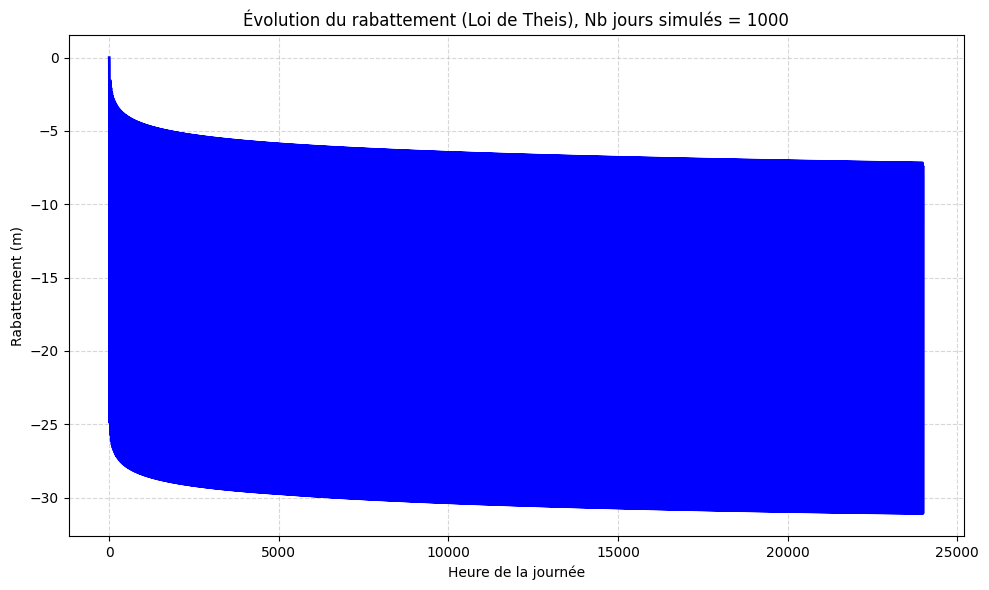

In [ ]:
# @title
# -----------------------------
# Affichage des résultats pour Theis
# -----------------------------

if loi == 0 :

    s_total_theis=theis_Qvar(Q,t_sec,S,r,T)
    s_total_theis*=(-1)           # Affichage dans les négatifs


    # ----------------------------------------------------------
    # CALCUL DES MINIMUMS JOURNALIERS DE RABATTEMENT POUR THEIS
    # ----------------------------------------------------------
    # Nombre de points par jour
    nb_points_per_day = len(heures) // nb_jours

    # Reshape du tableau pour séparer les jours
    s_reshaped_theis = s_total_theis[:nb_jours*nb_points_per_day].reshape(nb_jours, nb_points_per_day)

    # Valeurs minimales de chaque jour
    min_values_theis = s_reshaped_theis.min(axis=1)

    # Indices locaux des minimums dans chaque jour
    min_local_indices_theis = s_reshaped_theis.argmin(axis=1)

    # Conversion en indices globaux
    min_indices_theis = min_local_indices_theis + np.arange(nb_jours) * nb_points_per_day

    # Heures exactes des minimums
    t_min_exact_theis = heures[min_indices_theis]


    fig, ax = plt.subplots(figsize=(10,6))

    # Courbe de rabattement uniquement
    ax.plot(heures, s_total_theis, 'b-', linewidth=2, label="Rabattement (m)")

    # Configuration
    ax.set_xlabel("Heure de la journée")
    ax.set_ylabel("Rabattement (m)") # J'ai retiré la couleur forcée, c'est plus propre
    ax.grid(True, linestyle='--', alpha=0.5)

    plt.title("Évolution du rabattement (Loi de Theis), "+
    "Nb jours simulés = " + str(nb_jours))
    plt.tight_layout()


# -----------------------------
# Affichage des résultats pour Hantush
# -----------------------------

elif loi == 1:

    s_total_hantush=Hantush_Qvar(Q,t_sec,r,S,T,r_sur_B)
    s_total_hantush*=(-1)

    # ----------------------------------------------------------
    # CALCUL DES MINIMUMS JOURNALIERS DE RABATTEMENT POUR HANTUSH
    # ----------------------------------------------------------
    # Nombre de points par jour
    nb_points_per_day = len(heures) // nb_jours

    # Reshape du tableau pour séparer les jours
    s_reshaped_hantush = s_total_hantush[:nb_jours*nb_points_per_day].reshape(nb_jours, nb_points_per_day)

    # Valeurs minimales de chaque jour
    min_values_hantush = s_reshaped_hantush.min(axis=1)

    # Indices locaux des minimums dans chaque jour
    min_local_indices_hantush = s_reshaped_hantush.argmin(axis=1)

    # Conversion en indices globaux
    min_indices_hantush = min_local_indices_hantush + np.arange(nb_jours) * nb_points_per_day

    # Heures exactes des minimums
    t_min_exact_hantush = heures[min_indices_hantush]

    fig, ax = plt.subplots(figsize=(10,6))

    # Courbe de rabattement uniquement
    ax.plot(heures, s_total_hantush, 'b-', linewidth=2, label="Rabattement (m)")

    # Configuration
    ax.set_xlabel("Heure de la journée")
    ax.set_ylabel("Rabattement (m)")
    ax.grid(True, linestyle='--', alpha=0.5)

    plt.title("Évolution du rabattement (Loi Hantush), "+
    "Nb jours simulés = " + str(nb_jours))
    plt.tight_layout()

plt.show()

### **5. Détermination des minimums journaliers**

Pour chaque journée simulée, on cherche la **valeur minimale du rabattement**.

Cette information est importante car elle permet de vérifier que le pompage reste compatible avec la ressource sur le long terme.

La méthode consiste à découper le signal de rabattement jour par jour,
puis à identifier le minimum de chaque journée.


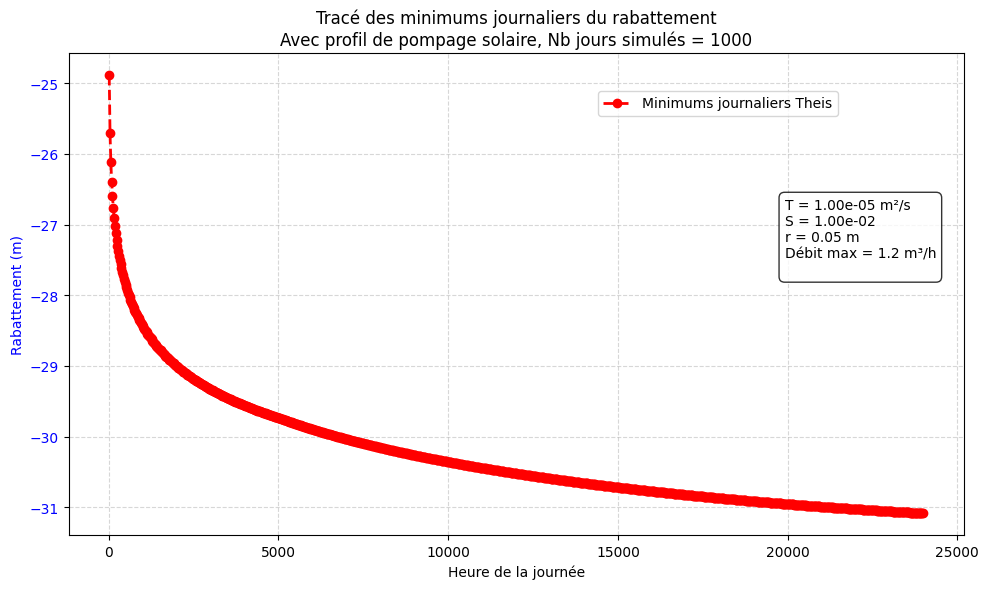

In [ ]:
# @title
# -----------------------------
# REPRESENTATION DES MINIMUMS JOURNALIERS
# -----------------------------
fig, ax1 = plt.subplots(figsize=(10,6))
if loi == 0:
    ax1.plot(t_min_exact_theis, min_values_theis, 'ro--', linewidth=2, markersize=6, label="Minimums journaliers Theis")
elif loi == 1:
    ax1.plot(t_min_exact_hantush, min_values_hantush, 'bo--', linewidth=2, markersize=6, label="Minimums journaliers Hantush")

ax1.set_xlabel("Heure de la journée")
ax1.set_ylabel("Rabattement (m)", color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True, linestyle='--', alpha=0.5)

# Légendes et mise en forme
fig.legend(loc="upper right", bbox_to_anchor=(0.85, 0.85))
plt.title(
    "Tracé des minimums journaliers du rabattement\n"
    "Avec profil de pompage solaire, Nb jours simulés = " + str(nb_jours)
)
plt.tight_layout()


# --- Encadré des paramètres ---
if loi==0:
    param_text = (
        f"T = {T:.2e} m²/s\n"
        f"S = {S:.2e}\n"
        f"r = {r} m\n"
        f"Débit max = {amplitude} m³/h\n"
    )
elif loi==1:
        param_text = (
        f"T = {T:.2e} m²/s\n"
        f"S = {S:.2e}\n"
        f"r = {r} m\n"
        f"r/B = {r_sur_B}\n"
        f"Débit max = {amplitude} m³/h\n"
    )

ax1.text(
    0.80,            # position x en coordonnées relatives (0 = gauche, 1 = droite)
    0.7,            # position y (1 = haut, 0 = bas)
    param_text,
    transform=ax1.transAxes,
    fontsize=10,
    verticalalignment='top',
    bbox=dict(
        facecolor='white',
        edgecolor='black',
        alpha=0.8,
        boxstyle='round,pad=0.4'
    )
)


plt.show()

In [ ]:
# @title
if loi == 0:
    print(
        f"Minimum de rabattement au bout de {nb_jours} jours (Theis) :"
        f"{min_values_theis[-1]:.3f} m"
    )
elif loi == 1:
    print(
        f"Minimum de rabattement au bout de {nb_jours} jours (Hantush) :"
        f"{min_values_hantush[-1]:.3f} m"
    )

Minimum de rabattement au bout de 1000 jours (Theis) :-31.083 m
